# Análisis de blockchain



## Configuración básica

Aquí vamos a importar el módulo pyspark y configurar una sesion SparkSession, por defecto se va a ejecutar en local con un solo ejecutor de spark.
Como vamos a tratar datos pequeños no tiene sentido correrlo en un cluster, pero estamos abiertos a esa posibilidad si lo necesitaramos cambiando el local por la ip del cluster.


In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *

spark = SparkSession.builder \
                    .master("local[4]") \
                    .config("spark.driver.memory", "4g") \
                    .getOrCreate()

sc = spark.sparkContext

## Cargando los datos

Para obtener el grafo representando las transacciones en la red Bitcoin, necesitamos cargar el conjunto de nodos representando las carteras, y el conjunto de artistas representando cada transaccion. Por ejemplo vamos a usar dos ficheros .parquet que fueron generados de los primeros bloques de blockchain.

In [2]:
raw_nodes = spark.read.load("../parquet-converter/output/nodes") \
                      .withColumnRenamed("_1", "id") \
                      .withColumnRenamed("_2", "Address")
raw_nodes.show(5)

+---+--------------------+
| id|             Address|
+---+--------------------+
|  0|bitcoinaddress_93...|
|  1|bitcoinaddress_4D...|
|  2|bitcoinaddress_BE...|
|  3|bitcoinaddress_4B...|
|  4|bitcoinaddress_44...|
+---+--------------------+
only showing top 5 rows



Como podemos observar, cara fila en la columna de Address contiene la cadena `bitcoinaddress_<hash>`, donde el hash es la dirección actual del bloque. 
Vamos a eliminar este prefijo.

In [3]:
nodes = raw_nodes.withColumn("Address", regexp_replace("Address", "bitcoinaddress_", "")).cache()
nodes.show(5)
nodes.count()

+---+--------------------+
| id|             Address|
+---+--------------------+
|  0|9303DBB4C75A56057...|
|  1|4D3826A813A4B4E9B...|
|  2|BECC6154EEF33464E...|
|  3|4B5E0300F11C2932F...|
|  4|44730B80C9D5EF65D...|
+---+--------------------+
only showing top 5 rows



546651

Podemos también verificar que estas direcciones son reales en https://blockchain.info/address/. 

In [4]:
raw_edges = spark.read.load("../parquet-converter/output/edges") \
                      .withColumnRenamed("srcId", "src") \
                      .withColumnRenamed("dstId", "dst") \
                      .drop("attr") \
                      .cache()
raw_edges.show(5)
raw_edges.count()

+------+------+
|   src|   dst|
+------+------+
|150102|107378|
|470403|107378|
|232249| 97703|
|539070| 97703|
|131174|176711|
+------+------+
only showing top 5 rows



2087249

## Limpieza de datos

Eliminar las auto referencias

In [5]:
edges = raw_edges.filter("src != dst")
edges.show(5)
edges.count()

+------+------+
|   src|   dst|
+------+------+
|150102|107378|
|470403|107378|
|232249| 97703|
|539070| 97703|
|131174|176711|
+------+------+
only showing top 5 rows



2081796

## Construyendo la representación del grafo

In [6]:
from graphframes import GraphFrame
g = GraphFrame(nodes, edges).cache()

In [7]:
from graphframes import *


#### Calculando el grado del vértice

In [8]:
vertexDegreesAndIds = g.inDegrees.join(g.outDegrees, "id")
vertexDegrees = vertexDegreesAndIds.drop("id")
vertexDegrees.show(5, False)

+--------+---------+
|inDegree|outDegree|
+--------+---------+
|5       |5        |
|2       |1        |
|2       |1        |
|2       |1        |
|6       |4        |
+--------+---------+
only showing top 5 rows



#### Calcular algunas estadísticas básicas

In [9]:
vertexDegrees.describe() \
             .show()

+-------+-----------------+------------------+
|summary|         inDegree|         outDegree|
+-------+-----------------+------------------+
|  count|           324431|            324431|
|   mean|6.188986255937318| 4.691345771519984|
| stddev|275.2198543574708|19.964350474456104|
|    min|                1|                 1|
|    max|           121885|              1994|
+-------+-----------------+------------------+



In [10]:
triang = g.triangleCount()

In [11]:
filtrado_ord=triang.select("id", "count").orderBy("count").summary()

In [26]:
labels =  g.labelPropagation(maxIter=5)
print(labels)

In [21]:
labels.select("id", "label").show(5)

+---+--------------------+---------+
| id|             Address|distances|
+---+--------------------+---------+
|  0|9303DBB4C75A56057...|       {}|
|  1|4D3826A813A4B4E9B...|       {}|
|  2|BECC6154EEF33464E...|       {}|
|  3|4B5E0300F11C2932F...|       {}|
|  4|44730B80C9D5EF65D...|       {}|
|  5|9B0A761783C82205C...|       {}|
|  6|ADC1CF2E398302CC6...|       {}|
|  7|68EC2B10A3B545463...|       {}|
|  8|96A386EBB2A7A8825...|       {}|
|  9|223610BB034D156BD...|       {}|
| 10|7155E9B6B53C8BE32...|       {}|
| 11|B56D845E4ECF5FD77...|       {}|
| 12|4F22E989EBD9C0B2D...|       {}|
| 13|B7DA4E091CFEA4293...|       {}|
| 14|C5BAC0E3F1F05C34B...|       {}|
| 15|4AC3942D08FFBF661...|       {}|
| 16|17C0E4446FB777F76...|       {}|
| 17|C6B9C9F57AE6EF01B...|       {}|
| 18|7A205ABDA9412F41F...|       {}|
| 19|CA555B7585F8B5924...|       {}|
| 20|E2C3F39DA2B77C8E0...|       {}|
| 21|CE79CB0A8B95BC998...|       {}|
| 22|91E153232D33E8CC7...|       {}|
| 23|D39690D5C5872946D...|       {}|
|

In [11]:
results = g.pageRank(resetProbability=0.15, tol=0.01)


In [13]:
results.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False).show(5)


+------+------------------+
|    id|          pagerank|
+------+------------------+
|266082| 67244.25700984268|
|134026| 66886.30636205853|
|449200| 2907.457314693666|
|449482|1627.7287254267771|
|425789| 587.4160843158339|
+------+------------------+
only showing top 5 rows



In [ ]:
type(triang)

size(triang)


TypeError: Invalid argument, not a string or column: DataFrame[count: bigint, id: bigint, Address: string] of type <class 'pyspark.sql.dataframe.DataFrame'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

C:\Users\Fernando\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


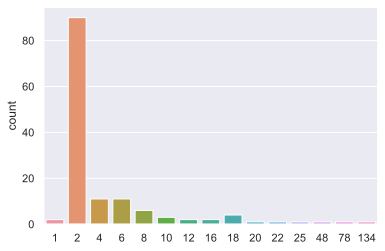

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
from scipy import stats
sns.set(color_codes=True)

_ = sns.countplot([int(i.inDegree) for i in vertexDegrees.sample(False, 0.0004).select("inDegree").collect()])

C:\Users\Fernando\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


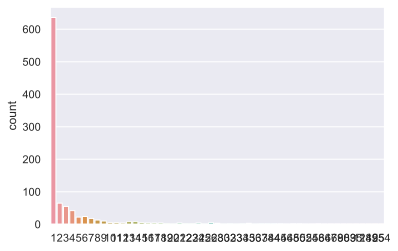

In [ ]:
_ = sns.countplot([int(i.outDegree) for i in vertexDegrees.sample(False, 0.003).select("outDegree").collect()])

In [ ]:
sns.jointplot(x="inDegree", y="outDegree", data=vertexDegrees.sample(False, 0.01, 42).toPandas());

In [ ]:
vertexDegrees.select(corr("inDegree", "outDegree")) \
             .show()

+-------------------------+
|corr(inDegree, outDegree)|
+-------------------------+
|      0.18298883961523846|
+-------------------------+



In [ ]:
probs = [i*1.0/20 for i in range(0,20)]
quantiles = vertexDegrees.approxQuantile("inDegree", probs, 0.03)
quantiles

[1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 4.0,
 4.0,
 6.0,
 8.0,
 14.0]

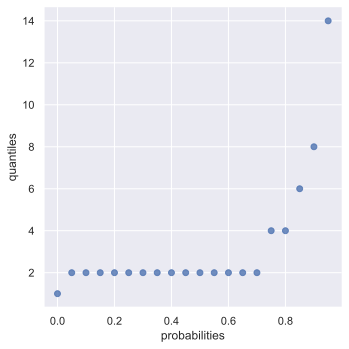

In [ ]:
import pandas as pd
p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})

sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

In [ ]:
def create_graph():
    nodes = spark.read.load("../parquet-converter/output/nodes").withColumnRenamed("_1", "id")
    raw_edges = spark.read.load("../parquet-converter/output/edges") \
                          .withColumnRenamed("srcId", "src").withColumnRenamed("dstId", "dst") \
                          .drop("attr")

    edges = raw_edges.filter("src != dst")
    self_loops = raw_edges.count() - edges.count()
    print("Graph " + id + " - self-loops count: " + str(self_loops))
    g = GraphFrame(nodes, edges)
    degrees = g.inDegrees.join(g.outDegrees, "id").drop("id")
    return [g, degrees]

g1, degrees1 = create_graph()

Graph 1 - self-loops count: 5453


In [ ]:
degrees1.describe().show()

+-------+-----------------+------------------+
|summary|         inDegree|         outDegree|
+-------+-----------------+------------------+
|  count|           324431|            324431|
|   mean|6.188986255937318| 4.691345771519984|
| stddev|275.2198543574708|19.964350474456104|
|    min|                1|                 1|
|    max|           121885|              1994|
+-------+-----------------+------------------+



In [ ]:
def plot_quantiles(degrees):
    probs = [i*1.0/15 for i in range(0,15)]
    quantiles = degrees.approxQuantile("outDegree", probs, 0.03)
    p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})
    sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

plot_quantiles(degrees1)
plot_quantiles(degrees2)

#### Encontrar patrones en el grafo por medio de filtros

In [ ]:
graph_with_degrees = GraphFrame(g.vertices.join(vertexDegreesAndIds, "id"), edges)
graph_with_degrees.vertices.show()


motifs = graph_with_degrees.find("(a)-[]->(b)") \
                           .filter("a.outDegree > 100") \
                           .filter("a.inDegree >= 1") \
                           .filter("b.outDegree >= 1") \
                           .filter("b.inDegree > 100")
motifs.show()
motifs.count()

+---+--------------------+--------+---------+
| id|             Address|inDegree|outDegree|
+---+--------------------+--------+---------+
|  6|ADC1CF2E398302CC6...|       2|        2|
|  7|68EC2B10A3B545463...|       6|        4|
| 19|CA555B7585F8B5924...|       2|        1|
| 22|91E153232D33E8CC7...|       2|        1|
| 26|CCF65F39D0460E2A1...|       6|        3|
| 29|2736D640B78C53986...|       2|        1|
| 31|B422365AF681E891B...|       2|        1|
| 34|8610B5758FF0D8836...|       2|        1|
| 43|0418097B1D868BC5D...|       2|        1|
| 50|B91704CD939D2726B...|       6|        9|
| 58|D395500A06B23CA53...|       2|        1|
| 68|B3B9946028C381D8D...|       2|        2|
| 71|0879476DC021F123A...|       2|        1|
| 72|80623210B8DF9A68C...|       2|        1|
| 77|462399531AD29795A...|      16|        8|
| 84|1CD24F8A2A9AF90F2...|       2|        1|
| 87|DCC595A9D72ACE7C6...|       2|        1|
| 94|B1E1A613FA276139F...|       2|        1|
| 95|07C59B5413C34DC36...|       1

137604

In [ ]:
print(motifs)

DataFrame[a: struct<id:bigint,Address:string,inDegree:int,outDegree:int>, b: struct<id:bigint,Address:string,inDegree:int,outDegree:int>]


## Visualización de un sub-grafo

Nuestros datos contienen muchos nodos y aristas así que vamos a mostrar solo una pequeña fracción del grafo de transacciones. Vamos a mostrar también todas las transacciones salientes de una dirección específica de bitcoin.

In [ ]:
from pyspark.sql.functions import col
import random

vertexOutDegrees = g.outDegrees
senders = vertexOutDegrees.join(nodes, vertexOutDegrees.id == nodes.id) \
                          .drop("id") \
                          .orderBy("outDegree", ascending=False)

# feel free to use any address that is present in the dataset
address = senders.take(1000)[556].Address

sub_graph = g.find("(src)-[e]->(dst)") \
             .filter(col('src.Address') == address)
    
def node_to_dict(r):
    return {
        'id': r[0],
        'label': r[1],
        'x': random.uniform(0,1),
        'y': random.uniform(0,1),
        'size': random.uniform(0.2,1)
    }

sub_nodes = sub_graph.select("dst.id", "dst.Address").distinct()
sub_edges = sub_graph.select("e.src", "e.dst")

target_nodes_dict = list(map(node_to_dict, sub_nodes.collect()))

def edge_to_dict(i, r):
    return {
        'id': i,
        'source': r[0],
        'target': r[1]
    }

sub_edges_dict = [edge_to_dict(i, r) for i, r in enumerate(sub_edges.collect())]

target_nodes_dict.append({
    'id': sub_edges.first()['src'],
    'label': address,
    'color': '#999',
    'x': -1,
    'y': 0.5,
    'size': 2
})



In [ ]:
%%javascript
require.config({
    paths: {
        sigmajs: 'https://cdnjs.cloudflare.com/ajax/libs/sigma.js/1.2.0/sigma.min'
    }
});

require(['sigmajs']);

<IPython.core.display.Javascript object>

In [ ]:
from IPython.core.display import display, HTML
from string import Template
import json

js_text_template = Template(open('js/sigma-graph.js','r').read())

graph_data = { 'nodes': target_nodes_dict, 'edges': sub_edges_dict }

js_text = js_text_template.substitute({'graph_data': json.dumps(graph_data),
                                       'container': 'graph-div'})

html_template = Template('''
<div id="graph-div" style="height:400px"></div>
<script> $js_text </script>
''')

HTML(html_template.substitute({'js_text': js_text}))

C:\Users\Fernando\AppData\Local\Temp\ipykernel_17652\2056111077.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(sub_edges.collect())

NameError: name 'sub_edges' is not defined

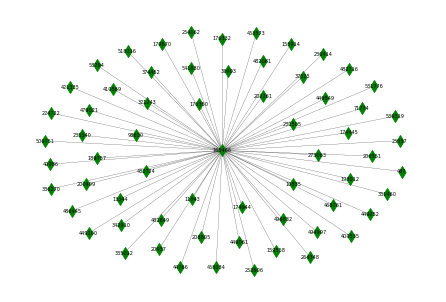

In [ ]:
import matplotlib.pyplot as plt
options = {
    'node_color': 'g',
    'node_size': 70,
    'width': 0.2,
    'node_shape': 'd',
    'with_labels': True,
    'font_size': 5,
}
nx.draw(G, **options)

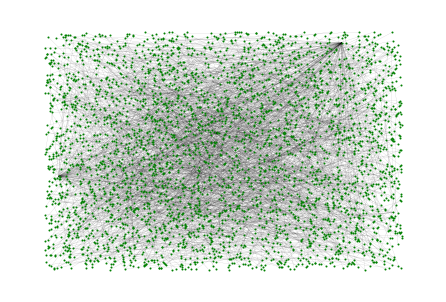

In [ ]:
sample_data = edges.sample(False, 0.001).collect()
G2 = nx.Graph()
G2.add_edges_from(sample_data)

options = {
    'node_color': 'g',
    'node_size': 1,
    'width': 0.05,
    'node_shape': 'o',
    'vmin': 100.1,
    'vmax': 10.1,
    'with_labels': False,
}
nx.draw_random(G2, **options)

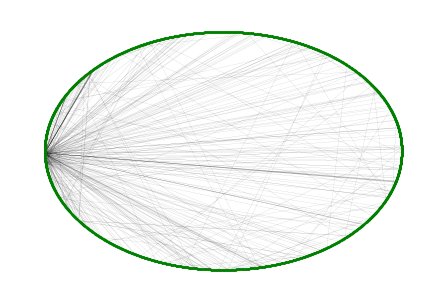

In [ ]:
nx.draw_shell(G2, **options)

In [ ]:
nx.draw_spring(G2, **options)

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

Desafortunadamente, NetworkX no cuenta con herramienta de zoom para los grafos, aunque podríamos explorar con zoom utilizando 'Gephi'.